# Compare NEXRAD Radar with KAZR

Within this notebook, we will look at comparing NEXRAD data with data collected from the KAZR radar (vertically pointing)

## Data
We have two data sources:

### NEXRAD Data
NEXRAD data is stored on AWS through the Open Data Initiative
* [Link to bucket](https://registry.opendata.aws/noaa-nexrad/)

There is a specific Python package called [nexradaws](https://github.com/aarande/nexradaws), which makes working with these data easier!

The nearest NEXRAD radars to the TRACER field campaign are:
* [Lake Charles (KLCH)](https://www.weather.gov/lch/?n=KLCH)
* [Houston/Galveston (KHGX)](https://www.weather.gov/hgx/)

We will be accessing data on the [NEXRAD AWS Bucket](https://registry.opendata.aws/noaa-nexrad/) (maintained by Unidata)

### KAZR Data
The KAZR data explored here is **exploratory** and ***has not been calibrated***, indicating that it is not meant to be used for analysis, but rather a proof-of-concept. It is a vertically pointing Ka-band radar.

From the official [ARM KAZR Documentation](https://armweb0-stg.ornl.gov/capabilities/instruments/kazr), “The Ka-band ARM zenith radar (KAZR) remotely probes the extent and composition of clouds at millimeter wavelengths. The KAZR is a zenith-pointing Doppler radar that operates at a frequency of approximately 35 GHz. The main purpose of this radar is to determine the first three Doppler moments (reflectivity, vertical velocity, and spectral width) at a range resolution of approximately 30 meters from near-ground to nearly 20 km in altitude.”

After finding data on the [ARM Data Hub using this query](https://adc.arm.gov/discovery/#/results/datastream::houarsclkazr1kolliasM1.c0), download the data and place in some data directory!



## Imports

In [269]:
import xarray as xr
import pyart
import nexradaws
import tempfile
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from distributed import LocalCluster, Client
import numpy as np
import xcollection as xc
import cartopy.feature as cfeature
import hvplot.xarray

In [3]:
cluster = LocalCluster()
client = Client(cluster)
client

/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 56477 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:56477/status,
Dashboard: http://127.0.0.1:56477/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56480,Workers: 4
Dashboard: http://127.0.0.1:56477/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:56514,Total threads: 3
Dashboard: http://127.0.0.1:56519/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:56484,


## Access NEXRAD Data
We can use the `NexradAwsInterface` class from `nexradaws` to acces the data, using the following steps:
- Establish an initial connection
- Query/subset for our desired site/time
- Download to some directory

In [4]:
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def download_radar_data(site='KLOT',
                        cache_location=tempfile.mkdtemp(),
                        target_time=datetime.utcnow()):
    """
    Accesses data from AWS S3
    
    Parameters
    ----------
    site: str, default='KLOT' (Chicago)
       Site to download data from (ex. 'KLOT')
    cache_location: str, default=tempfile.mkdtemp()
       Where to place the cached data files
    target_time: datetime.datetime, default=datetime.utcnow()
       Time index to search for
    
    Returns
    -------
    file : str
        Path to the NEXRAD file
    """
    
    # Convert the datetime to UTC
    target_time = target_time.astimezone(pytz.utc)
    
    # Setup the initial connection
    aws_connection = nexradaws.NexradAwsInterface()
    
    # Check for available scans
    scans = aws_connection.get_avail_scans(target_time.year,
                                           target_time.month,
                                           target_time.day,
                                           site)
    
    # Retrieve the scan times
    scan_times = [scan.scan_time for scan in scans]
    
    # Loop through and find good scans
    good_scans = []
    good_times = []
    for i in range(len(scans)):
        if scan_times[i] is not None:
            good_times.append(scan_times[i])
            good_scans.append(scans[i])

    print(f'Found {len(good_scans)} good scans')
    print(f'Found {len(good_times)} good times')
    
    # Find the nearest time using our helper function
    nearest_time = nearest(good_times, target_time)
    
    # Locate closest time in our scans
    closest_time_index = good_times.index(nearest_time)
    
    # Download the file
    file = aws_connection.download(good_scans[closest_time_index],
                                   f'{cache_location}/{site}')
    
    # Return the filepath
    return file.success[0].filepath
    
    

### Download the file

In [261]:
time = datetime(2022, 3, 22, 13, 48, 0)
KLCH_file = download_radar_data(site='KLCH',
                                cache_location='/Volumes/Samsung_T5/argonne/nexrad-data',
                                target_time=time)

KHGX_file = download_radar_data(site='KHGX',
                                cache_location='/Volumes/Samsung_T5/argonne/nexrad-data',
                                target_time=time)

Found 266 good scans
Found 266 good times
Downloaded KLCH20220322_184856_V06
1 out of 1 files downloaded...0 errors
Found 264 good scans
Found 264 good times
Downloaded KHGX20220322_184940_V06
1 out of 1 files downloaded...0 errors


## Run Through the Analysis
Now that we have the data, let's start our analysis!

### Convert to an Xarray Object

We add a couple of helper functions to convert each sweep to a dataset, then the full volume to a dictionary of datasets

In [263]:
def create_dataset_from_sweep(radar, sweep=0, field=None):
    """
    Creates an xarray.Dataset from sweeps
    """
    
    # Grab the range
    range = radar.range['data']
    
    # Grab the elevation
    elevation = radar.get_elevation(sweep)
    
    # Grab the azimuth
    azimuth = radar.get_azimuth(sweep)
    
    # Grab the x, y, z values
    x, y, z = radar.get_gate_x_y_z(sweep)
    
    # Grab the lat, lon, and elevation
    lat, lon, alt = radar.get_gate_lat_lon_alt(sweep)
    
    # Add the fields
    field_dict = {}
    for field in list(radar.fields):
        field_dict[field]=(["azimuth", "range"], radar.get_field(sweep, field))
    
    ds = xr.Dataset(
        data_vars=field_dict,
         coords=dict(
             x=(["azimuth", "range"], x),
             y=(["azimuth", "range"], y),
             z=(["azimuth", "range"], z),
             lat=(["azimuth", "range"], lat),
             lon=(["azimuth", "range"], lon),
             alt=(["azimuth", "range"], alt),
             azimuth=azimuth,
             elevation=elevation,
             sweep=np.array([sweep]),
             range=range),
    )
    
    return ds.chunk()

### Create an "Xradar" object
For now, we utilize `xcollection` which is a dictionary of datasets with some added functionality

In [264]:
def convert_to_xradar(radar):
    """
    Converts from radar to xradar
    """
    ds_list = []
    sweeps = radar.sweep_number['data']
    for sweep in sweeps:
        ds_list.append(create_dataset_from_sweep(radar, sweep))
    
    # Convert the numpy array to a list of strings
    dict_keys = [x for x in list(sweeps.astype(str))]
    
    # Zip the keys and datasets and turn into a dictionary
    dict_of_dsets = dict(zip(dict_keys, ds_list))
    
    return xc.Collection(dict_of_dsets)

## Run our workflow

### Read the data into PyART

In [ ]:
klch_radar = pyart.io.read(KLCH_file)
khgz_radar = pyart.io.read(KHGX_file)

### Convert to Xradar

In [265]:
klch_xradar = convert_to_xradar(klch_radar)
khgz_xradar = convert_to_xradar(khgz_radar)

### Visualize our Output
Start first with xarray! We use matplotlib directly, specifying our axes

/Users/mgrover/opt/anaconda3/envs/tracer-dev/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


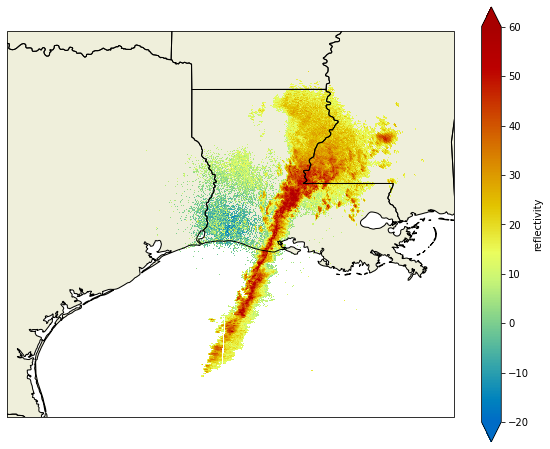

In [271]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection=ccrs.PlateCarree())

klch_xradar['0'].reflectivity.plot(ax=ax,
                                   y='lat',
                                   x='lon',
                                   cmap='pyart_HomeyerRainbow',
                                   vmin=-20,
                                   vmax=60)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)

In [282]:
klch_xradar['0'].reflectivity.hvplot.quadmesh(x='lon',
                                              y='lat',
                                              rasterize=True,
                                              width=600,
                                              height=400,
                                              clim=(-20, 60),
                                              projection=ccrs.PlateCarree(),
                                              cmap='pyart_HomeyerRainbow',
                                              features=['land', 'lakes','borders','ocean'])

:DynamicMap   []
   :Overlay
      .Land.I    :Feature   [Longitude,Latitude]
      .Lakes.I   :Feature   [Longitude,Latitude]
      .Borders.I :Feature   [Longitude,Latitude]
      .Ocean.I   :Feature   [Longitude,Latitude]
      .Image.I   :Image   [lon,lat]   (reflectivity)